In [156]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from fairlearn.metrics import MetricFrame, selection_rate, equalized_odds_difference, false_positive_rate, false_negative_rate
import warnings
warnings.filterwarnings('ignore')

In [157]:
# loading the data
X = pd.read_csv("./data/acsincome_ca_features.csv")
y = pd.read_csv("./data/acsincome_ca_labels.csv")
feature_names = X.columns
target_name = y.columns
X.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0


In [158]:
# checking for missing values
print(X.isnull().sum())
print(y.isnull().sum())

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


In [159]:
# shuffle the data, select 10%
X, y = shuffle(X, y, random_state=1)

num_samples = int(len(X)*0.1)
X, y = X[:num_samples], y[:num_samples]

print(X.shape)
print(y.shape)

(19566, 10)
(19566, 1)


In [160]:
# Standrize and split the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [161]:
param_grid_SVC = {
    'C': [0.1, 1, 10, 50, 100],
    'kernel': ['rbf']
}
param_grid_randomF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],                   
    'learning_rate': [0.01, 0.1, 1.0, 2.0]
}
param_grid_gradientboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}

models = []
models.append(('SVM', SVR(), param_grid_SVC))
models.append(('RF', RandomForestClassifier(), param_grid_randomF))
models.append(('AB', AdaBoostClassifier(), param_grid_adaboost))
models.append(('GB', GradientBoostingClassifier(), param_grid_gradientboost))

In [162]:
names = []
best_estimators = []
best_hyperparams = []
best_scores = []

for name, model, params in models:
    print( ">> GridSearch of {} in progress ...".format(name))
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5)
    grid_search.fit(X_train,y_train)
    names.append(name)
    best_estimators.append(grid_search.best_estimator_)
    best_hyperparams.append(grid_search.best_params_)
    best_scores.append(grid_search.best_score_)

>> GridSearch of SVM in progress ...
>> GridSearch of RF in progress ...
>> GridSearch of AB in progress ...
>> GridSearch of GB in progress ...


In [163]:
print(best_hyperparams)

[{'C': 0.1, 'kernel': 'rbf'}, {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}, {'learning_rate': 1.0, 'n_estimators': 200}, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}]


In [164]:
df = pd.DataFrame({
    'Model': names,
    'Best estimator': best_estimators,
    'Best hyperparameters': best_hyperparams,
    'Best score': best_scores
})
display(df)

,Model,Best estimator,Best hyperparameters,Best score
0,SVM,SVR(C=0.1),"{'C': 0.1, 'kernel': 'rbf'}",NaN
1,RF,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.812356
2,AB,"(DecisionTreeClassifier(max_depth=1, random_st...","{'learning_rate': 1.0, 'n_estimators': 200}",0.814656
3,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.820406


In [165]:
train_scores = []
train_mean_scores = []
train_std_deviation = []

test_scores = []
test_mean_scores = []
test_std_deviation = []

for model in best_estimators:
    train_result = cross_val_score(model, X_train, y_train, cv=5)
    train_scores.append(train_result)
    train_mean_scores.append(round(train_result.mean(), 2))
    train_std_deviation.append(round(train_result.std(), 3))

    test_result = cross_val_score(model, X_test, y_test, cv=5)
    test_scores.append(test_result)
    test_mean_scores.append(round(test_result.mean(), 2))
    test_std_deviation.append(round(test_result.std(), 3))

data = pd.DataFrame({
    'Model': names,
    'Train mean': train_mean_scores,
    'Train std': train_std_deviation,
    'Test mean': test_mean_scores,
    'Test std': test_std_deviation
})

display(data)

,Model,Train mean,Train std,Test mean,Test std
0,SVM,0.39,0.012,0.35,0.040
1,RF,0.81,0.003,0.79,0.014
2,AB,0.81,0.005,0.80,0.012
3,GB,0.82,0.005,0.79,0.015


<Axes: xlabel='Model'>

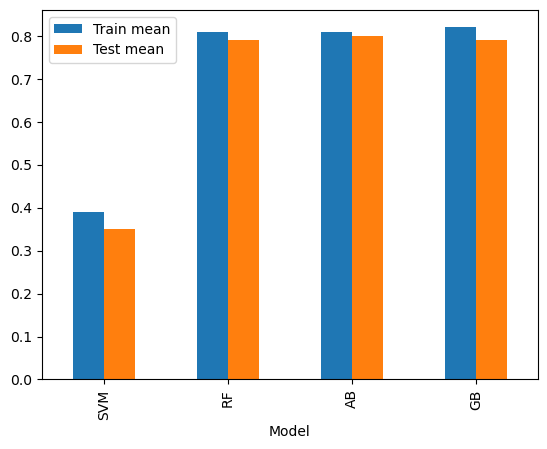

In [166]:
data.plot(
    x='Model',
    y=['Train mean','Test mean'], 
    kind='bar'
) 

In [167]:
def plot_confusion_matrix(cm) :
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [False, True])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

>> SVM
Accuracy score :  0.78308635666837
Classification report :
               precision    recall  f1-score   support

       False       0.80      0.83      0.82      2292
        True       0.75      0.71      0.73      1622

    accuracy                           0.78      3914
   macro avg       0.78      0.77      0.77      3914
weighted avg       0.78      0.78      0.78      3914



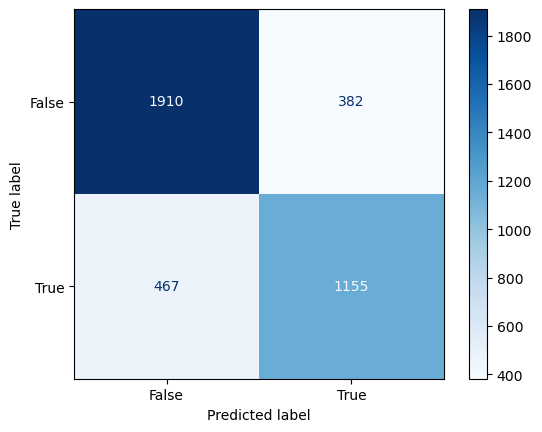

>> RF
Accuracy score :  0.8019928461931528
Classification report :
               precision    recall  f1-score   support

       False       0.82      0.84      0.83      2292
        True       0.77      0.75      0.76      1622

    accuracy                           0.80      3914
   macro avg       0.80      0.79      0.80      3914
weighted avg       0.80      0.80      0.80      3914



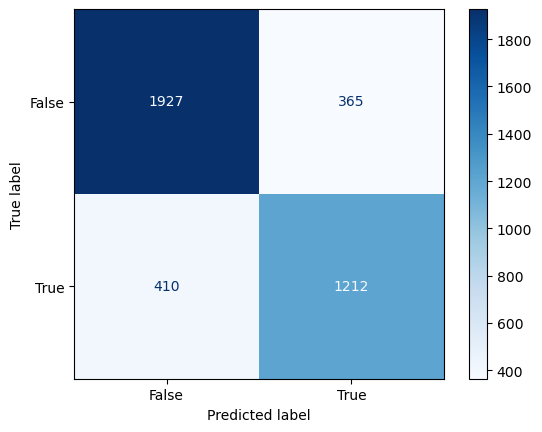

>> AB
Accuracy score :  0.8063362289218191
Classification report :
               precision    recall  f1-score   support

       False       0.83      0.84      0.84      2292
        True       0.77      0.76      0.76      1622

    accuracy                           0.81      3914
   macro avg       0.80      0.80      0.80      3914
weighted avg       0.81      0.81      0.81      3914



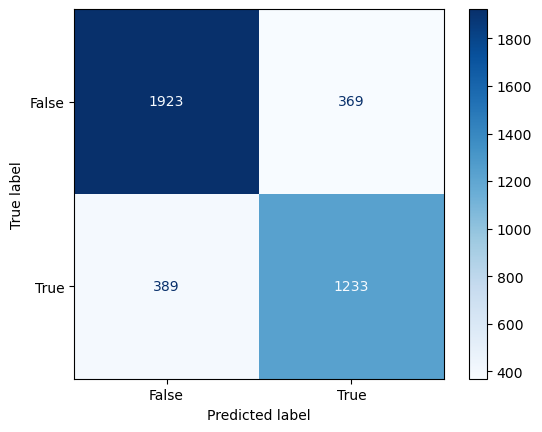

>> GB
Accuracy score :  0.8078691875319366
Classification report :
               precision    recall  f1-score   support

       False       0.83      0.84      0.84      2292
        True       0.77      0.76      0.77      1622

    accuracy                           0.81      3914
   macro avg       0.80      0.80      0.80      3914
weighted avg       0.81      0.81      0.81      3914



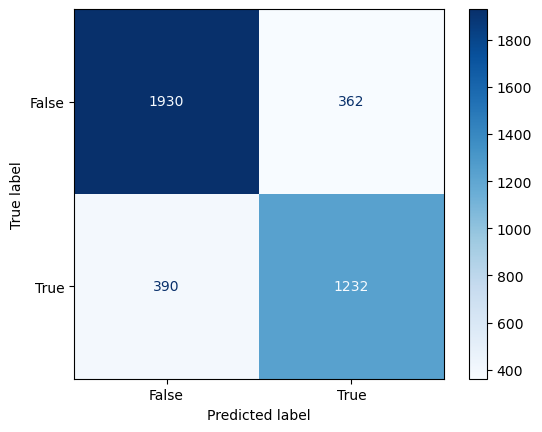

In [168]:
accuracy_scores = []
y_pred_ca_dataset = []
for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_test)
    y_pred_ca_dataset.append(y_pred)
    acc_score = accuracy_score(y_test, y_pred.round())
    accuracy_scores.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_test, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred.round()))


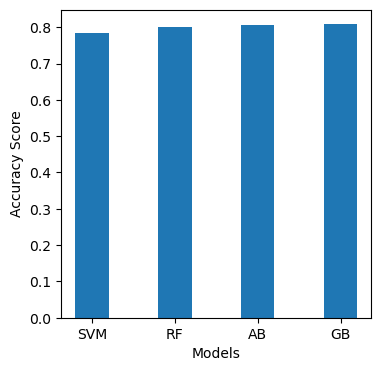

In [169]:
plt.figure(figsize=(4, 4))
plt.bar(names, accuracy_scores, width=0.4)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')  
plt.show()

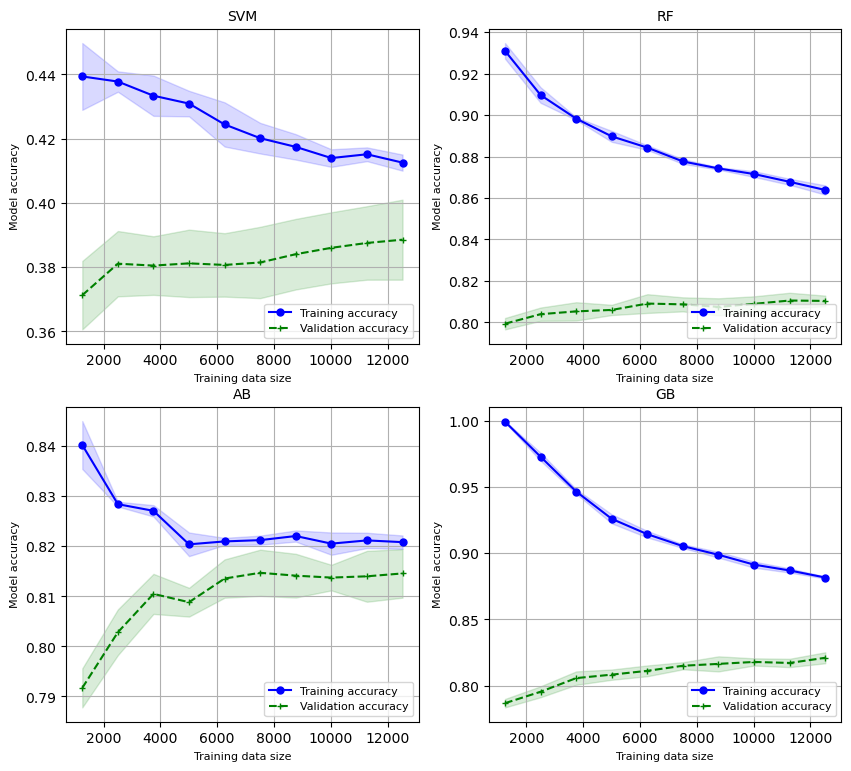

In [170]:
# Use learning curve to get training and test scores along with train sizes
plt.figure(figsize=(10,9))

for index, model in enumerate(best_estimators):
    plt.subplot(2,2,index+1)
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=y_train, 
                                                            cv=5, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(names[index], fontsize=10)
    plt.xlabel('Training data size', fontsize=8)
    plt.ylabel('Model accuracy', fontsize=8)
    plt.grid()
    plt.legend(loc='lower right', fontsize=8)
plt.show()

In [171]:
# ############# COLORADO DATASET ###################
X_co = pd.read_csv("./data/acsincome_co_allfeaturesTP2.csv")
y_co = pd.read_csv("./data/acsincome_co_labelTP2.csv")

feature_names_co = X_co.columns
target_name_co = y_co.columns

X_co.head()

# checking for missing values
print(X_co.isnull().sum())
print(y_co.isnull().sum())

# shuffle the data, select 10%
X_co, y_co = shuffle(X_co, y_co, random_state=1)
num_samples_ = int(len(X_co)*0.1)
X_co, y_co = X_co[:num_samples], y_co[:num_samples]

# Standrize the data
scaler_co = StandardScaler()
X_co = scaler_co.fit_transform(X_co)

X_co = pd.DataFrame(X_co, columns = feature_names_co)
y_co = pd.DataFrame(y_co, columns = target_name_co)

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


>> COLORADO DATASET
>> SVM
Accuracy score :  0.7612695492180312
Classification report :
               precision    recall  f1-score   support

           0       0.80      0.79      0.80     11480
           1       0.71      0.72      0.71      8086

    accuracy                           0.76     19566
   macro avg       0.75      0.75      0.75     19566
weighted avg       0.76      0.76      0.76     19566



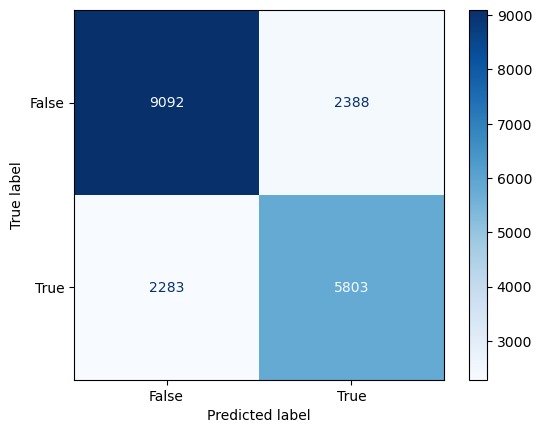

>> RF
Accuracy score :  0.7647449657569253
Classification report :
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     11480
           1       0.72      0.70      0.71      8086

    accuracy                           0.76     19566
   macro avg       0.76      0.76      0.76     19566
weighted avg       0.76      0.76      0.76     19566



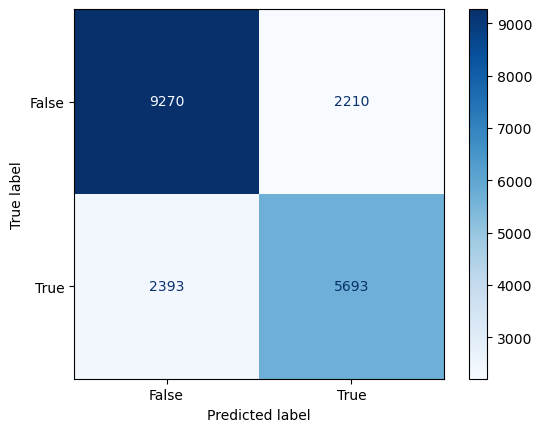

>> AB
Accuracy score :  0.7610651129510375
Classification report :
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     11480
           1       0.70      0.73      0.72      8086

    accuracy                           0.76     19566
   macro avg       0.75      0.76      0.75     19566
weighted avg       0.76      0.76      0.76     19566



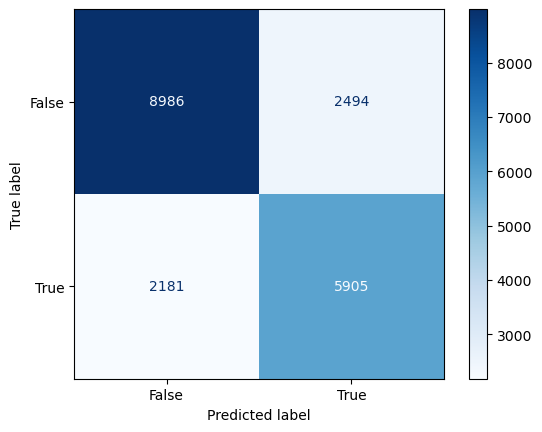

>> GB
Accuracy score :  0.7499233363998773
Classification report :
               precision    recall  f1-score   support

           0       0.77      0.83      0.80     11480
           1       0.72      0.64      0.68      8086

    accuracy                           0.75     19566
   macro avg       0.74      0.73      0.74     19566
weighted avg       0.75      0.75      0.75     19566



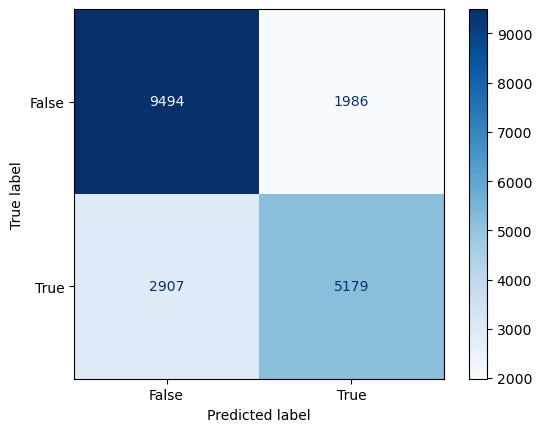

In [172]:
print(">> COLORADO DATASET")
accuracy_scores_co = []

for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_co)
    acc_score = accuracy_score(y_co, y_pred.round())
    accuracy_scores_co.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_co, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_co, y_pred.round()))

In [173]:
# ############# NEVADA DATASET ###################
X_ne = pd.read_csv("./data/acsincome_ne_allfeaturesTP2.csv")
y_ne = pd.read_csv("./data/acsincome_ne_labelTP2.csv")

feature_names_ne = X_ne.columns
target_name_ne = y_ne.columns

X_ne.head()

# checking for missing values
print(X_ne.isnull().sum())
print(y_ne.isnull().sum())

# shuffle the data, select 10%
X_ne, y_ne = shuffle(X_ne, y_ne, random_state=1)
num_samples_ = int(len(X_ne)*0.1)
X_ne, y_ne = X_ne[:num_samples], y_ne[:num_samples]

# Standrize the data
scaler_ne = StandardScaler()
X_ne = scaler_ne.fit_transform(X_ne)

X_ne = pd.DataFrame(X_ne, columns = feature_names_ne)
y_ne = pd.DataFrame(y_ne, columns = target_name_ne)

AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
RELP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
PINCP    0
dtype: int64


>> NEVADA DATASET
>> SVM
Accuracy score :  0.738618451553083
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.73      0.79      7417
           1       0.56      0.76      0.64      3368

    accuracy                           0.74     10785
   macro avg       0.71      0.74      0.72     10785
weighted avg       0.77      0.74      0.75     10785



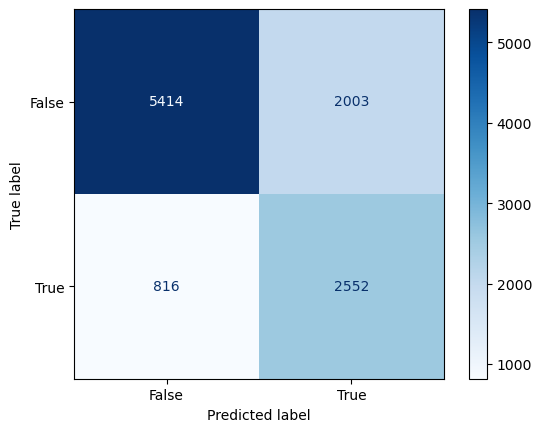

>> RF
Accuracy score :  0.7440890125173852
Classification report :
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      7417
           1       0.57      0.73      0.64      3368

    accuracy                           0.74     10785
   macro avg       0.72      0.74      0.72     10785
weighted avg       0.77      0.74      0.75     10785



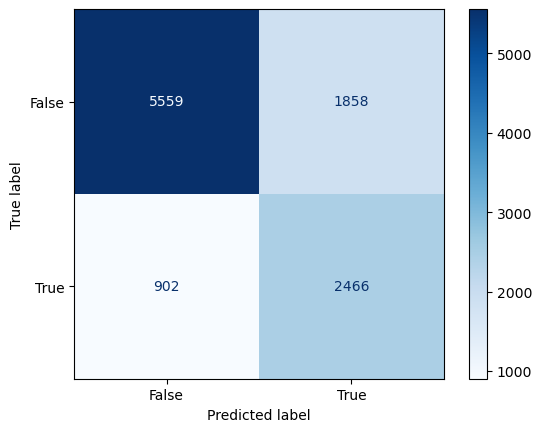

>> AB
Accuracy score :  0.7155308298562819
Classification report :
               precision    recall  f1-score   support

           0       0.86      0.71      0.77      7417
           1       0.53      0.74      0.62      3368

    accuracy                           0.72     10785
   macro avg       0.69      0.72      0.70     10785
weighted avg       0.75      0.72      0.72     10785



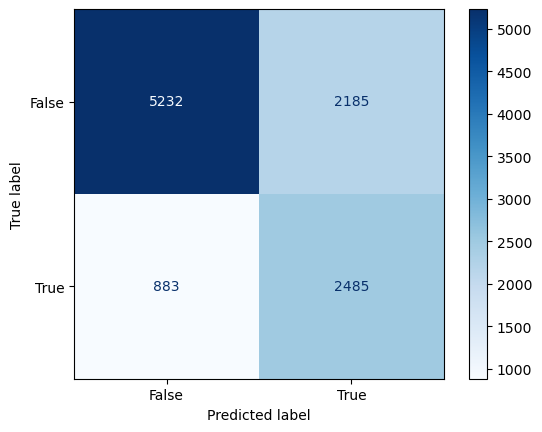

>> GB
Accuracy score :  0.7345387111729254
Classification report :
               precision    recall  f1-score   support

           0       0.85      0.75      0.79      7417
           1       0.56      0.71      0.62      3368

    accuracy                           0.73     10785
   macro avg       0.70      0.73      0.71     10785
weighted avg       0.76      0.73      0.74     10785



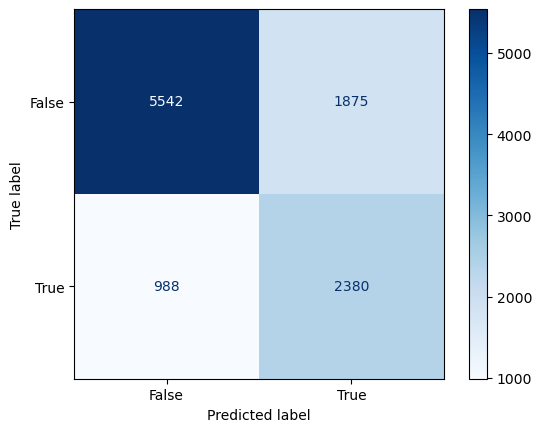

In [174]:
print(">> NEVADA DATASET")
accuracy_scores_ne = []

for index, best_model in enumerate(best_estimators):
    y_pred = best_model.predict(X_ne)
    acc_score = accuracy_score(y_ne, y_pred.round())
    accuracy_scores_ne.append(acc_score)
    
    print(">> {}".format(names[index]))
    print("Accuracy score : ", acc_score)
    print("Classification report :\n", classification_report(y_ne, y_pred.round()))
    plot_confusion_matrix(confusion_matrix(y_ne, y_pred.round()))

,Model,Californie,Colorado,Nevada
0,SVM,0.783086,0.761270,0.738618
1,RF,0.801993,0.764745,0.744089
2,AB,0.806336,0.761065,0.715531
3,GB,0.807869,0.749923,0.734539


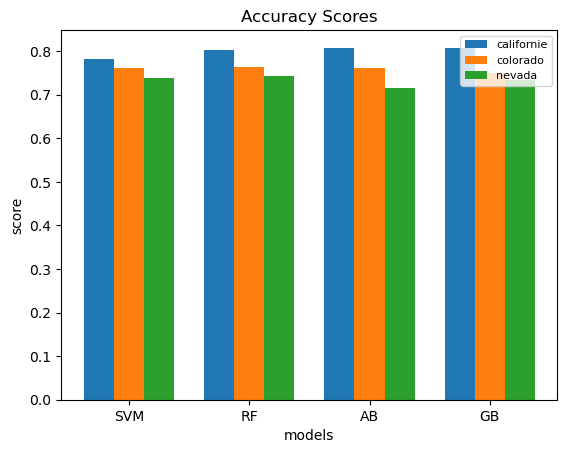

In [175]:
data = pd.DataFrame({
    'Model': names,
    'Californie': accuracy_scores,
    'Colorado': accuracy_scores_co,
    'Nevada': accuracy_scores_ne
})

display(data)

ind = np.arange(4)  
width = 0.25
  
bar1 = plt.bar(ind, accuracy_scores, width) 
bar2 = plt.bar(ind+width, accuracy_scores_co, width) 
bar3 = plt.bar(ind+width*2, accuracy_scores_ne, width) 
  
plt.xlabel("models") 
plt.ylabel("score") 
plt.title("Accuracy Scores") 
  
plt.xticks(ind+width, names, rotation=0) 
plt.legend((bar1, bar2, bar3), ('californie', 'colorado', 'nevada'), fontsize="8")
plt.show()

In [176]:
# ####################################### TP2 ##################################################
X_train = pd.DataFrame(X_train, columns = feature_names)
y_train = pd.DataFrame(y_train, columns = target_name)
X_test = pd.DataFrame(X_test, columns = feature_names)
y_test = pd.DataFrame(y_test, columns = target_name)

In [179]:
# ################## -1- Explicabilité ################## #
# a) 
from sklearn.inspection import permutation_importance

xtrain = pd.DataFrame(X_train)
ytrain = pd.DataFrame(y_train)
training_dataset = pd.concat([xtrain, ytrain], axis=1)
correlations_l = training_dataset.corr()['PINCP'].drop('PINCP')
print(correlations_l)


AGEP     0.004963
COW     -0.032808
SCHL    -0.037110
MAR     -0.035965
OCCP     0.004681
POBP     0.061943
RELP    -0.028673
WKHP     0.024794
SEX      0.073172
RAC1P    0.056340
Name: PINCP, dtype: float64


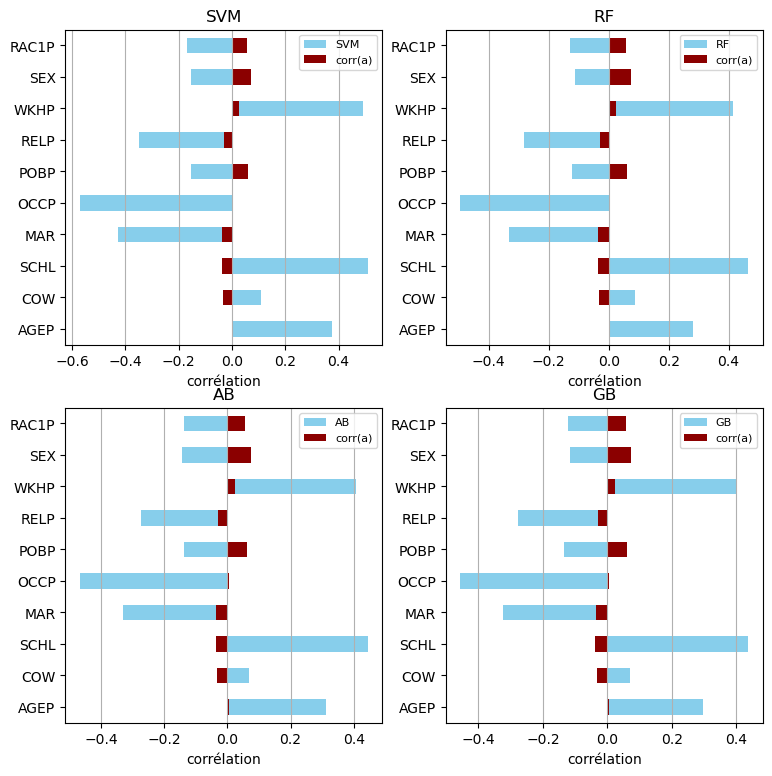

In [220]:
# b)
correlations = []
for predLables in y_pred_ca_dataset:    
    xtest = pd.DataFrame(X_test)
    ypred = pd.DataFrame({'PINCP' : predLables})
    correlations.append(pd.concat([xtest, ypred], axis=1).corr()['PINCP'].drop('PINCP'))

plt.figure(figsize=(9,9))
for index, corr in enumerate(correlations):
    plt.subplot(2,2,index+1)
    corr.plot(kind='barh', color='skyblue', label=names[index])
    correlations_l.plot(kind='barh', color='darkred', label='corr(a)')
    plt.xlabel('corrélation')
    plt.title(names[index])
    plt.grid(axis='x')
    plt.legend(fontsize="8")

plt.show()    

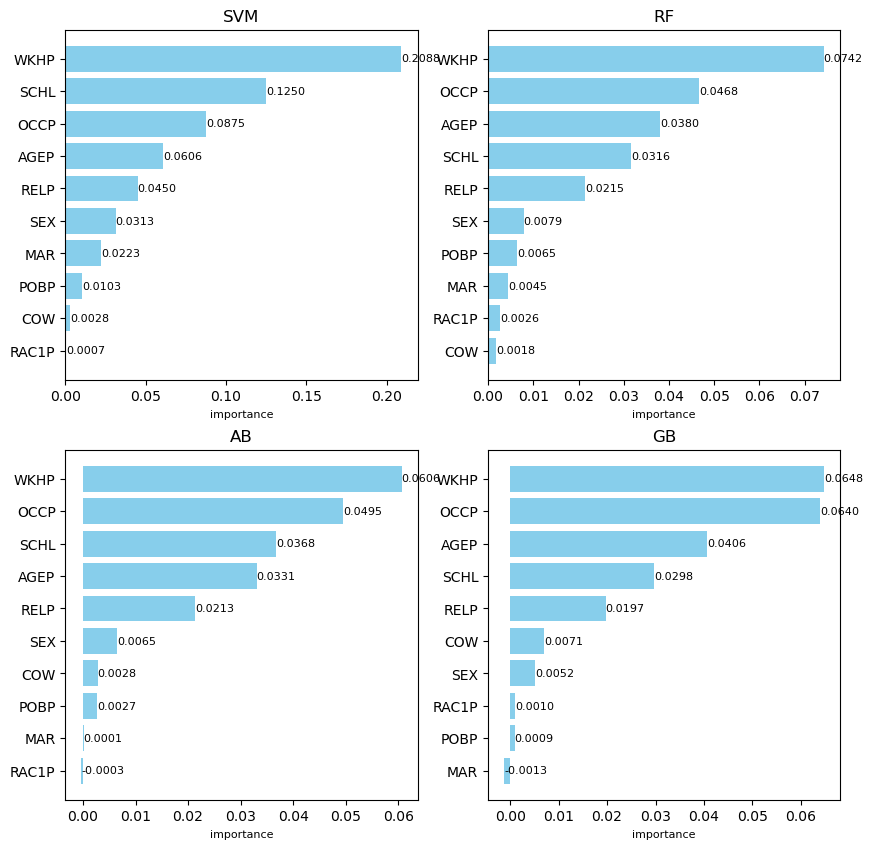

In [228]:
# c)
plt.figure(figsize=(10,10))
for index, model in enumerate(best_estimators):
    plt.subplot(2,2,index+1)

    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean
    
    sorted_idx = importance.argsort()
    bars = plt.barh(range(len(sorted_idx)), importance[sorted_idx], align='center', color='skyblue')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])  # Utilisation des vrais noms de features
    plt.xlabel('importance', fontsize='8')
    plt.title(names[index])

    for i, val in enumerate(importance[sorted_idx]):
        plt.text(val, i, f'{val:.4f}', ha='left', va='center', fontsize='8')

plt.show()

m  5691   5691
f  5094   5094
>> SVM
la matrice de confusion pour SEX='male'


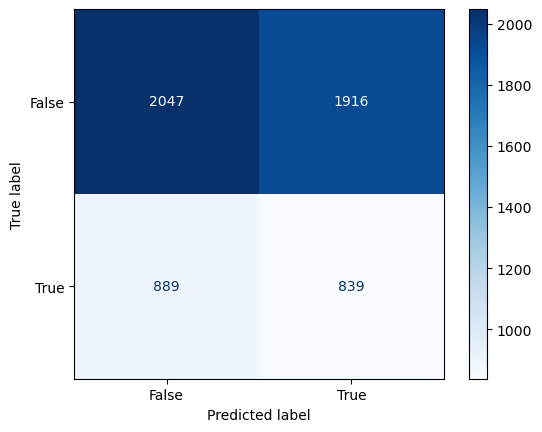

la matrice de confusion pour SEX='female'


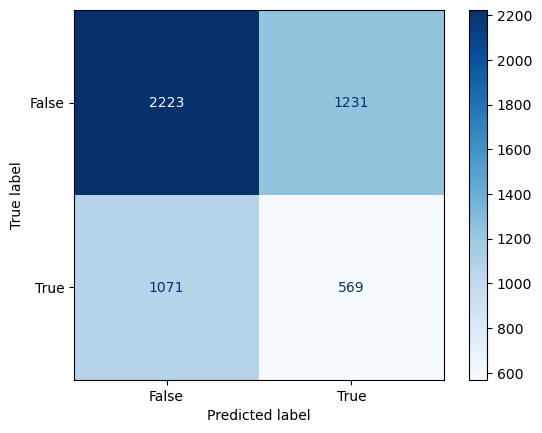

>> RF
la matrice de confusion pour SEX='male'


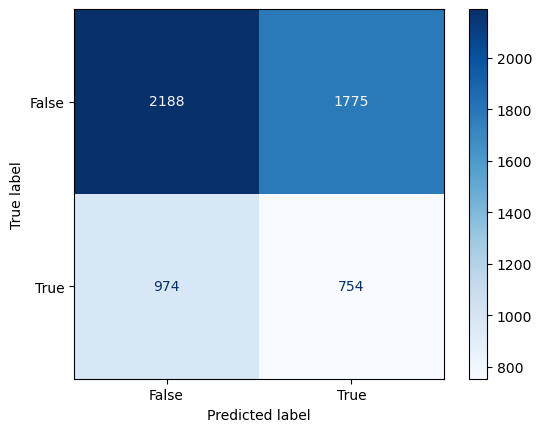

la matrice de confusion pour SEX='female'


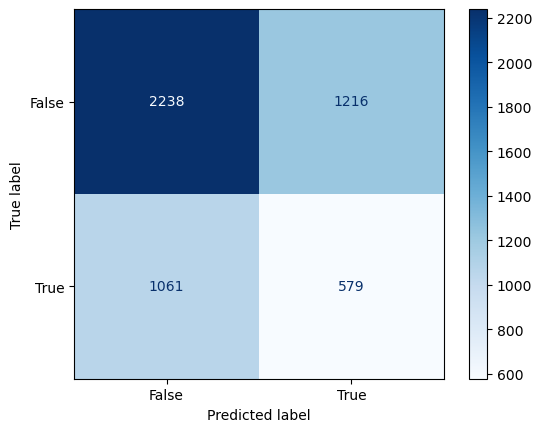

>> AB
la matrice de confusion pour SEX='male'


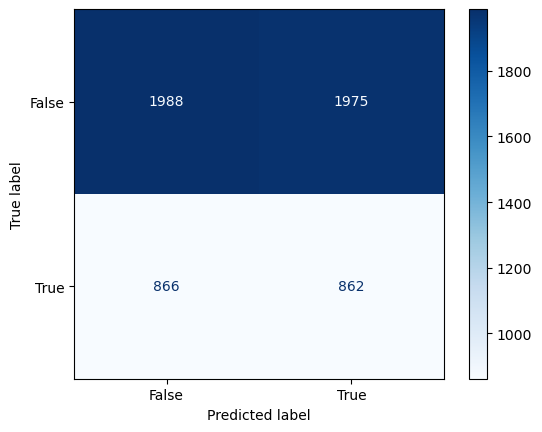

la matrice de confusion pour SEX='female'


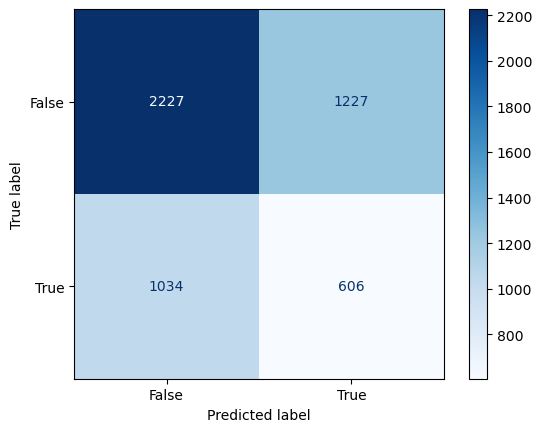

>> GB
la matrice de confusion pour SEX='male'


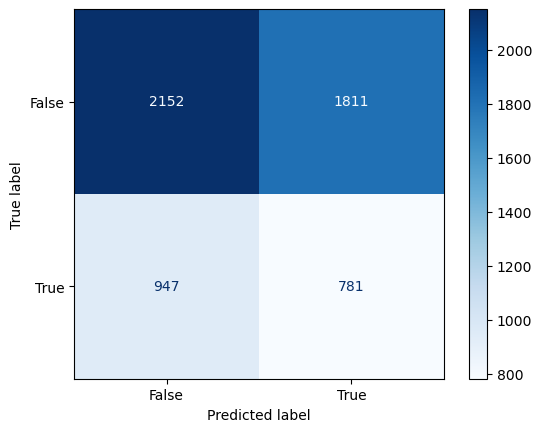

la matrice de confusion pour SEX='female'


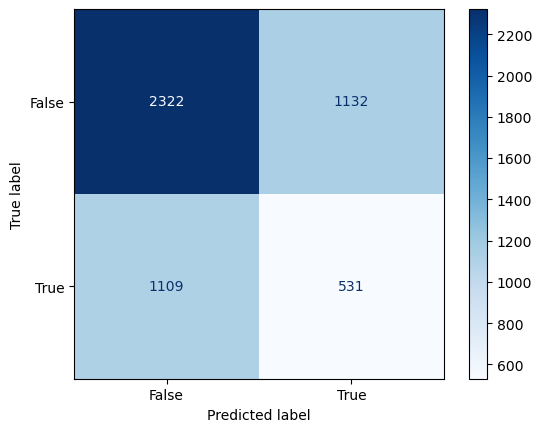

In [229]:
# ################## -2- Equité des modèles ################## #
# a)
dataset = pd.concat([X_ne, y_ne], axis=1)

male_group_dataset = dataset[dataset['SEX'] == -0.9460959372092215]
female_group_dataset = dataset[dataset['SEX'] == 1.0569752608279706]

y_ne_male = male_group_dataset[['PINCP']].copy()
y_ne_female = female_group_dataset[['PINCP']].copy()

X_ne_male = male_group_dataset.drop('PINCP', axis=1)
X_ne_female = female_group_dataset.drop('PINCP', axis=1)

print("m ",len(X_ne_male)," ",len(y_ne_male))
print("f ",len(X_ne_female)," ",len(y_ne_female))

for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    print("la matrice de confusion pour SEX='male'")
    y_pred_male = best_model.predict(X_ne_male)
    plot_confusion_matrix(confusion_matrix(y_ne_male, y_pred_male.round()))
    print("la matrice de confusion pour SEX='female'")
    y_pred_female = best_model.predict(X_ne_female)
    plot_confusion_matrix(confusion_matrix(y_ne_female, y_pred_female.round()))


In [230]:
# b) Installation of fairlearn library is required (pip install fairlearn)
for index, best_model in enumerate(best_estimators):
    print(">>> {}".format(names[index]))

    # selection_rate : Pour le training
    print(">> Train set - selection_rate :")
    y_pred_train = best_model.predict(X_train)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_train, y_pred=y_pred_train, sensitive_features=X_train['SEX'])
    print(metric_frame.by_group)
    
    # selection_rate : Pour le test
    print(">> Test set - selection_rate :")
    y_pred_test = best_model.predict(X_test)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_test, y_pred=y_pred_test, sensitive_features=X_test['SEX'])
    print(metric_frame.by_group)

    
    # equalized_odds_difference : Pour le training
    print(">> Train set - equalized_odds_difference :")
    y_pred_train = best_model.predict(X_train)
    y_true_mapped = np.array(y_train, dtype=int)
    y_pred_mapped = np.array(y_pred_train, dtype=int)
    metric_parity = equalized_odds_difference(y_true=y_true_mapped, y_pred=y_pred_mapped, sensitive_features=X_train['SEX'],method='between_groups')
    print(metric_parity)

    # equalized_odds_difference : Pour le test
    print(">> Test set - equalized_odds_difference :")
    y_pred_test = best_model.predict(X_test)
    y_true_mapped_ = np.array(y_test, dtype=int)
    y_pred_mapped_ = np.array(y_pred_test, dtype=int)
    metric_parity = equalized_odds_difference(y_true=y_true_mapped_, y_pred=y_pred_mapped_, sensitive_features=X_test['SEX'],method='between_groups')
    print(metric_parity)
    

>>> SVM
>> Train set - selection_rate :
SEX
-0.944500    0.0
 1.058761    0.0
Name: selection_rate, dtype: float64
>> Test set - selection_rate :
SEX
-0.944500    0.0
 1.058761    0.0
Name: selection_rate, dtype: float64
>> Train set - equalized_odds_difference :
0.0791024071872089
>> Test set - equalized_odds_difference :
0.0788596570247346
>>> RF
>> Train set - selection_rate :
SEX
-0.944500    0.462544
 1.058761    0.351874
Name: selection_rate, dtype: float64
>> Test set - selection_rate :
SEX
-0.944500    0.454283
 1.058761    0.344771
Name: selection_rate, dtype: float64
>> Train set - equalized_odds_difference :
0.03747815313075398
>> Test set - equalized_odds_difference :
0.06392659425340219
>>> AB
>> Train set - selection_rate :
SEX
-0.944500    0.472831
 1.058761    0.332115
Name: selection_rate, dtype: float64
>> Test set - selection_rate :
SEX
-0.944500    0.475457
 1.058761    0.334423
Name: selection_rate, dtype: float64
>> Train set - equalized_odds_difference :
0.086236

In [231]:
# c) 

X = pd.read_csv("./data/acsincome_ca_features_without_sex.csv")
y = pd.read_csv("./data/acsincome_ca_labels.csv")

# shuffle the data, select 10%
X, y = shuffle(X, y, random_state=1)

num_samples = int(len(X)*0.1)
X, y = X[:num_samples], y[:num_samples]

# Standrize and split the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X,y, test_size=0.2)

>> SVM


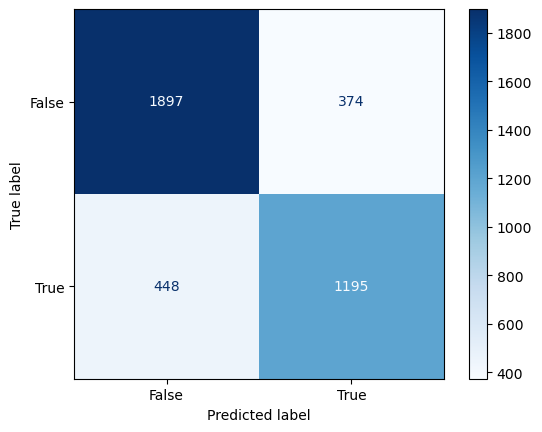

>> RF


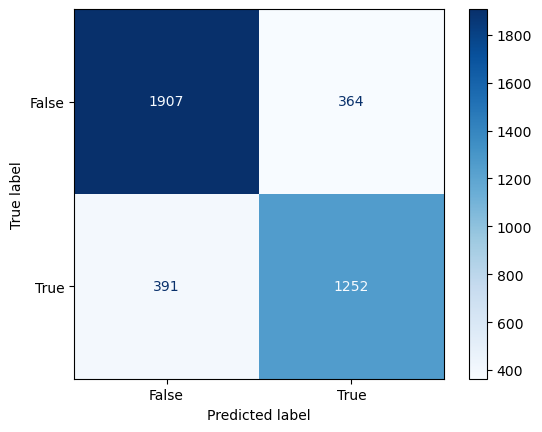

>> AB


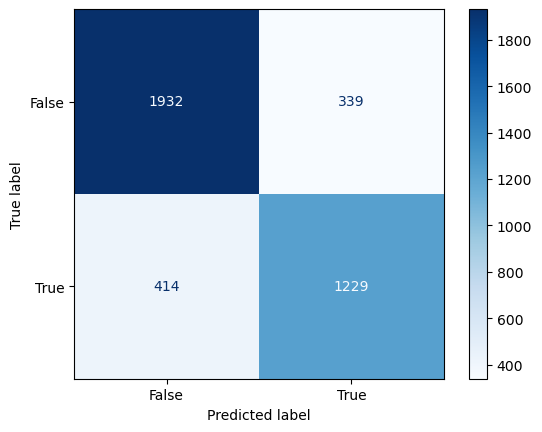

>> GB


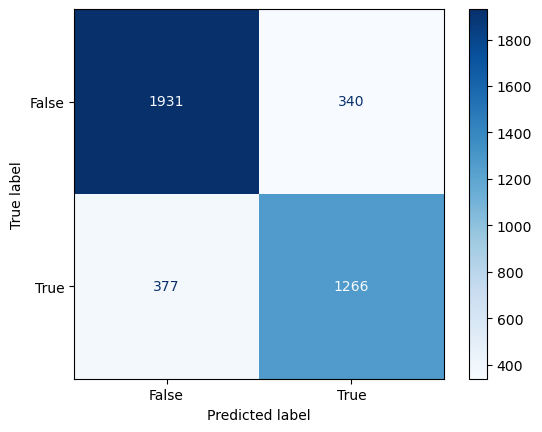

In [232]:
# we kept the same best models as before with the same hyperparameters, and we create new model instances of them
models = [SVR(C= 0.1, kernel= 'rbf')]
models.append( RandomForestClassifier(max_depth = 10, min_samples_leaf = 2, min_samples_split= 2, n_estimators =  100))
models.append(AdaBoostClassifier(learning_rate= 1.0, n_estimators=200))
models.append(GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=200))

for index, model in enumerate(models):
    print(">> {}".format(names[index]))
    model.fit(X_train_new,y_train_new)
    y_pred_new = model.predict(X_test_new)
    plot_confusion_matrix(confusion_matrix(y_test_new, y_pred_new.round()))


In [233]:
# f)
for index, best_model in enumerate(best_estimators):
    print(">> {}".format(names[index]))
    
    # selection_rate : Pour le training
    print(">> Train set - selection_rate :")
    y_pred_train = best_model.predict(X_train)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_train, y_pred=y_pred_train, sensitive_features=X_train['RAC1P'])
    print(metric_frame.by_group)
    
    # selection_rate : Pour le test
    print(">> Test set - selection_rate :")
    y_pred_test = best_model.predict(X_test)
    metric_frame = MetricFrame(metrics= selection_rate, y_true=y_test, y_pred=y_pred_test, sensitive_features=X_test['RAC1P'])
    print(metric_frame.by_group)

    
    # equalized_odds_difference : Pour le training
    print(">> Train set - equalized_odds_difference :")
    y_pred_train = best_model.predict(X_train)
    y_true_mapped = np.array(y_train, dtype=int)
    y_pred_mapped = np.array(y_pred_train, dtype=int)
    metric_parity = equalized_odds_difference(y_true=y_true_mapped, y_pred=y_pred_mapped, sensitive_features=X_train['RAC1P'],method='between_groups')
    print(metric_parity)

    # equalized_odds_difference : Pour le test
    print(">> Test set - equalized_odds_difference :")
    y_pred_test = best_model.predict(X_test)
    y_true_mapped_ = np.array(y_test, dtype=int)
    y_pred_mapped_ = np.array(y_pred_test, dtype=int)
    metric_parity = equalized_odds_difference(y_true=y_true_mapped_, y_pred=y_pred_mapped_, sensitive_features=X_test['RAC1P'],method='between_groups')
    print(metric_parity)

>> SVM
>> Train set - selection_rate :
RAC1P
-0.703969    0.0
-0.360952    0.0
-0.017935    0.0
 0.325083    0.0
 0.668100    0.0
 1.011117    0.0
 1.354135    0.0
 1.697152    0.0
 2.040169    0.0
Name: selection_rate, dtype: float64
>> Test set - selection_rate :
RAC1P
-0.703969    0.0
-0.360952    0.0
-0.017935    0.0
 0.325083    0.0
 0.668100    0.0
 1.011117    0.0
 1.354135    0.0
 1.697152    0.0
 2.040169    0.0
Name: selection_rate, dtype: float64
>> Train set - equalized_odds_difference :
0.2857142857142857
>> Test set - equalized_odds_difference :
0.25
>> RF
>> Train set - selection_rate :
RAC1P
-0.703969    0.451447
-0.360952    0.354571
-0.017935    0.322917
 0.325083    0.500000
 0.668100    0.102564
 1.011117    0.503172
 1.354135    0.238095
 1.697152    0.119493
 2.040169    0.359765
Name: selection_rate, dtype: float64
>> Test set - selection_rate :
RAC1P
-0.703969    0.445577
-0.360952    0.309942
-0.017935    0.280000
 0.325083    1.000000
 0.668100    0.000000
 1.

In [234]:
# we kept the same best models as before with the same hyperparameters, and we create new model instances of them
models = [SVR(C= 0.1, kernel= 'rbf')]
models.append(RandomForestClassifier(max_depth = 10, min_samples_leaf = 4, min_samples_split= 10, n_estimators =  200))
models.append(AdaBoostClassifier(learning_rate= 1.0, n_estimators=200))
models.append(GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100))

# Enlever la feature RAC1P du dataset
X_train.drop(columns=['RAC1P'], inplace=True)
X_test.drop(columns=['RAC1P'], inplace=True)

>> SVM


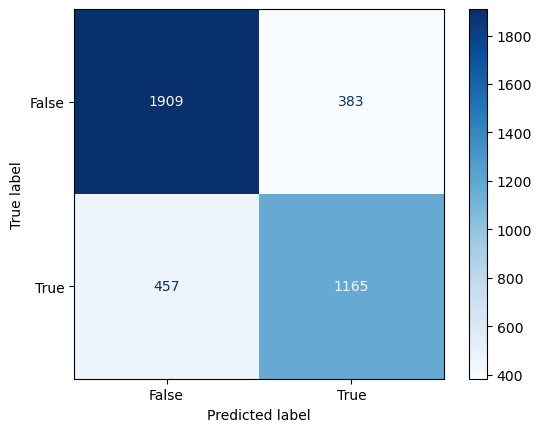

>> RF


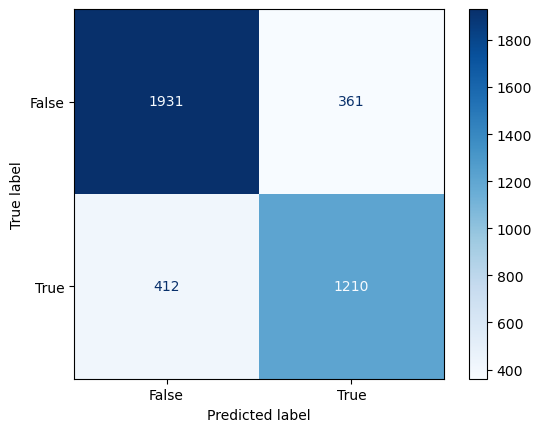

>> AB


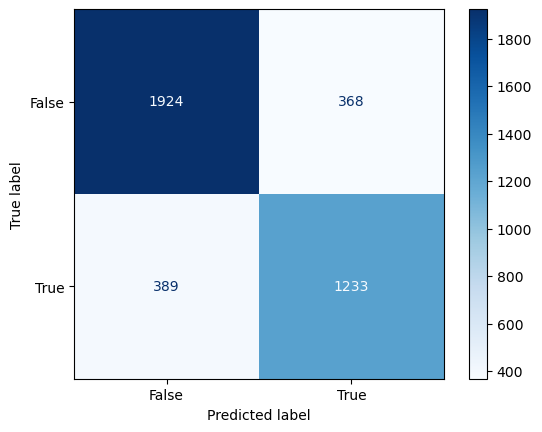

>> GB


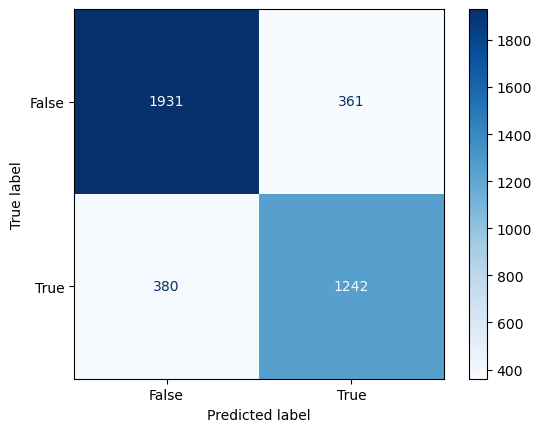

In [235]:
for index, model in enumerate(models):
    print(">> {}".format(names[index]))
    model.fit(X_train,y_train)
    y_pred_ = model.predict(X_test)
    plot_confusion_matrix(confusion_matrix(y_test, y_pred_.round()))